In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import sys 
import os

root_path = 'C://Users//HP//projects//DiplomaThesis'
sys.path.append(f'{root_path}')

from plots import LatexFigure, corrplot
from data import Meta, Selected

%load_ext autoreload 
%autoreload 2
%matplotlib inline

nn_names_dict = {
    "-1":"LR",
    "32":"NN1",
    "32,16":"NN2",
    "32,16,8":"NN3",
    "32,16,8,4":"NN4",
    "32,16,8,4,2":"NN5"
}

def df_heatmap(df, column_groups:list=None, cmap=plt.cm.Blues, flip_cbar:bool=False, show_cbar:bool=True, scale:int=2, vmin=None):
    
    # Create as many column subplots as there are column groups
    if column_groups == None: 
        column_groups = [df.columns.tolist()]
        
    fig, axes = plt.subplots(nrows=1, ncols=len(column_groups), figsize=(6.5,7),
                         gridspec_kw={"width_ratios":[len(group) for group in column_groups]})
    # fix axes if there is only one columns group from integer to list
    if len(column_groups) == 1: 
        axes = [axes]
    
    # Populate all axes
    vmin = df.min().min() if vmin is None else vmin
    kw = {'cmap':cmap, 'vmin':vmin, 'vmax':df.max().max()}
    for i, group in enumerate(column_groups): 
        im = axes[i].pcolor(df[group], **kw)
    
    # Y labels for first group are the index of the df
    labels = [meta.sc_to_latex.get(label) for label in df.index.values.tolist()]
    axes[0].set_yticks(np.arange(0.5, len(df.index)))
    axes[0].set_yticklabels(labels)
    axes[0].invert_yaxis()
    
    # Y labels for rest of groups are empty
    for i in range(1,len(column_groups)):
        axes[i].invert_yaxis()
        axes[i].set_yticks([])
    
    # Set X labels for each group (column names of the df)
    for i, group in enumerate(column_groups): 
        axes[i].set_xticks(np.arange(0.5, len(group), 1))
        axes[i].set_xticklabels(group)
        axes[i].xaxis.set_ticks_position('top')    
    
    # Optionally add colorbar, optionally flip it
    if show_cbar:
        cbar = plt.colorbar(im)
        if flip_cbar:
            cbar.ax.invert_yaxis() 
    
    # Make the width of space between subplots smaller
    plt.subplots_adjust(wspace=0.025)
    
    # Convert to LatexFigure to change font and figsize
    fig = LatexFigure(plt.gcf())
    fig.fit(scale=scale)
    plt.show()

def df_heatmap_old(df, scale=2, vmin=0, vmax=None, cmap=plt.cm.Blues, flip_cbar=False, show_cbar=True):
    %matplotlib inline
    fig, axis = plt.subplots() 
    heatmap = axis.pcolor(df, cmap=cmap, vmin=vmin, vmax=vmax)
    labels = [meta.sc_to_latex.get(label) for label in df.index.values.tolist()]
    plt.yticks(np.arange(0.5, len(df.index), 1), labels)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    if show_cbar:
        cbar = plt.colorbar(heatmap)
        if flip_cbar:
            cbar.ax.invert_yaxis() 
    fig = LatexFigure(plt.gcf())
    fig.fit(scale=scale)

def subset_models(ar, df, hidden_layers=None, ytrain=None):
    if hidden_layers and not ytrain: 
        sub = (ar["hidden_layers"]==hidden_layers) 
    elif ytrain and not hidden_layers: 
        sub = (ar["ytrain"]==ytrain)
    elif ytrain and hidden_layers: 
        sub = (ar["hidden_layers"]==hidden_layers) & (ar["ytrain"]==ytrain)
    else: 
        sub = df.columns
    return df[sub]

def get_corr_of_seeds(ar, df):
    corr = dict()
    for ytrain in [12,13,14,15,16]:
        corr["{}".format(ytrain)] = dict()
        for hidden_layers in ["-1","32","32,16","32,16,8","32,16,8,4","32,16,8,4,2"]:
            sub = (ar["hidden_layers"]==hidden_layers) & (ar["ytrain"]==ytrain)
            corr["{}".format(ytrain)]["{}".format(hidden_layers)] = df[sub].transpose().corr().dropna(how="all").dropna(how="all", axis=1).values.mean()
    return corr

def load_dataframes(fpath):
    ar = pd.read_csv(os.path.join(fpath, "args.csv"), index_col=0)
    pe = pd.read_csv(os.path.join(fpath, "performance.csv"), index_col=0)
    ig = pd.read_csv(os.path.join(fpath, "integrated_gradients_global.csv"), index_col=0)
    mr = pd.read_csv(os.path.join(fpath, "model_reliance.csv"), index_col=0)
    return ar, pe, ig, mr

def name(ar, df, variables):
    old_names = df.columns.tolist()
    lists = [ar.loc[old_names][var].values.astype(str).tolist() for var in variables]
    df.columns = ["-".join(l) for l in list(zip(*lists))]
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_orders(row):
    array = row.values
    temp = sorted(list(array))
    res = np.array([temp.index(i) for i in array])
    return pd.Series(res, row.index)

def get_parts(row, nparts):
    array = row.values
    temp = sorted(list(array))
    res = np.array([temp.index(i) for i in array])
    labels = list(reversed((np.arange(nparts)+1)*(30/nparts)))
    return pd.qcut(pd.Series(res, row.index).rank(method='first'),nparts,labels).astype(float)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
column_groups_dict = {
    "ensemble": [["LR"],['NN1', 'NN2', 'NN3', 'NN4', 'NN5']],
    'seeds':None
}

df_naming_dict = {
    "ensemble": ["nn_name"],
    "seeds": ['nn_name_short', "seed"]
}

def fe_blues(df,mode="ensemble", vmin=None):
    df = subset_models(ar, df, hidden_layers=None, ytrain=16).transpose()
    df = name(ar, df, df_naming_dict.get(mode))
    df_heatmap(df, column_groups = column_groups_dict.get(mode), vmin=vmin)

def fe_heatmap(df, mode="ensemble"):
    df = df.apply(lambda x: get_parts(x,6), axis=1)
    df = subset_models(ar, df, hidden_layers=None, ytrain=16).transpose()
    df = name(ar, df, df_naming_dict.get(mode))
    df_heatmap(df, column_groups = column_groups_dict.get(mode),  cmap=plt.cm.inferno_r, flip_cbar=True)
    
def fe_top(df, mode='ensemble'):
    df = (df.apply(lambda x: get_orders(x), axis=1)>=20)
    df = subset_models(ar, df, hidden_layers=None, ytrain=16).transpose()
    df = name(ar, df, df_naming_dict.get(mode))
    df_heatmap(df, column_groups = column_groups_dict.get(mode), show_cbar=False)

def fe_bottom(df,mode="ensemble"):
    df = (df.apply(lambda x: get_orders(x), axis=1)<=10)
    df = subset_models(ar, df, hidden_layers=None, ytrain=16).transpose()
    df = name(ar, df, df_naming_dict.get(mode))
    df_heatmap(df, column_groups = column_groups_dict.get(mode), show_cbar=False)

def load_results(fpath):
    ar, pe, ig, mr = load_dataframes(fpath)
    ig = ig[SORTING]
    mr = mr[SORTING]
    ar["nn_name"] = ar[["hidden_layers"]].replace(nn_names_dict)
    ar["nn_name_short"] = [s[-1:] for s in ar.nn_name]
    return ar, pe, ig, mr


In [58]:
meta = Meta()
meta.load()

#dataset = Selected()
#dataset.load()

In [59]:
# Get sorting
fpath = os.path.join("results", "selected","ensembles")
ar, pe, ig, mr = load_dataframes(fpath)
SORTING = subset_models(ar, ig, hidden_layers=None, ytrain=16).mean().abs().sort_values(ascending=False).index.tolist()
SORTING_LATEX = [meta.sc_to_latex.get(k) for k in SORTING]

# Ensembles

In [123]:
ar, pe, ig, mr = load_results(os.path.join("results", "selected","ensembles"))

### Integrated gradients show size of impact of features on the prediction values

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


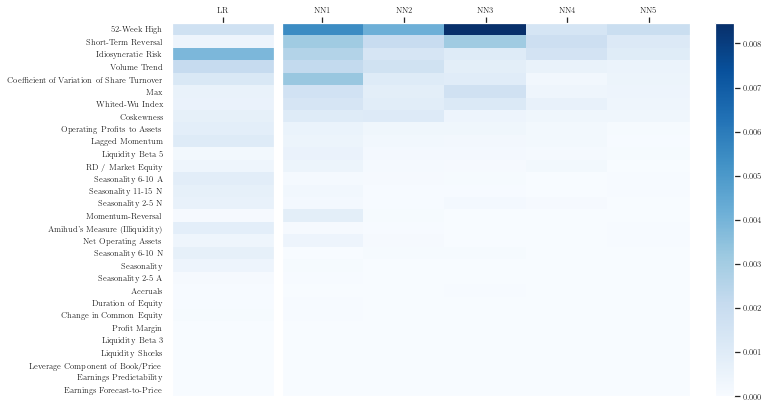

In [124]:
fe_blues(ig)

### Model Reliance shows how distorting a features harms the model's performance

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


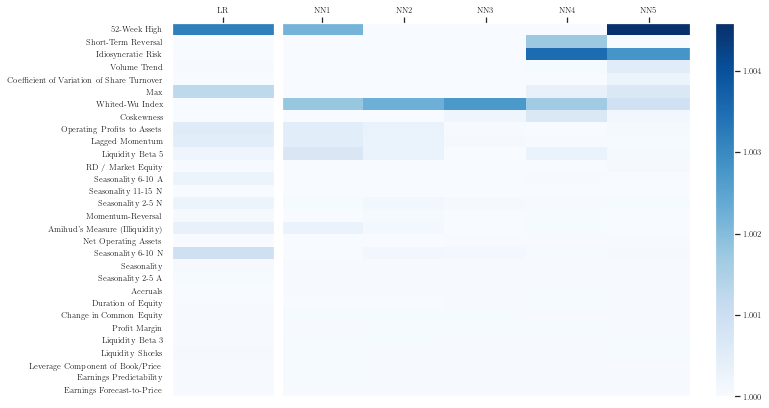

In [126]:
fe_blues(mr, vmin=1)

### All ensembles agree on 10 most influential features (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


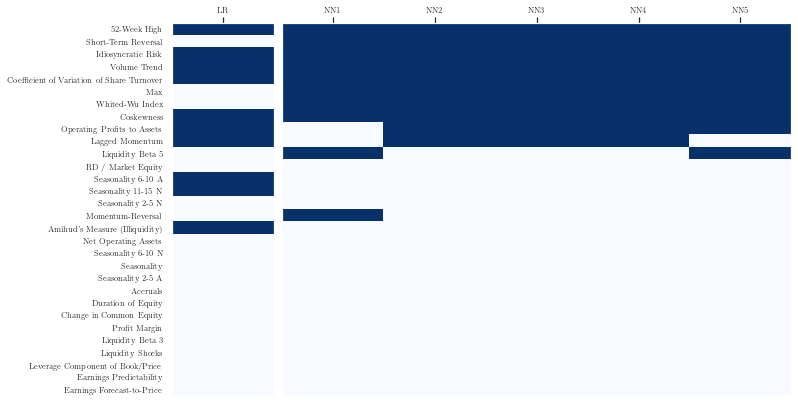

In [68]:
fe_top(ig)

### All ensembles agree on 10 least influential features (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


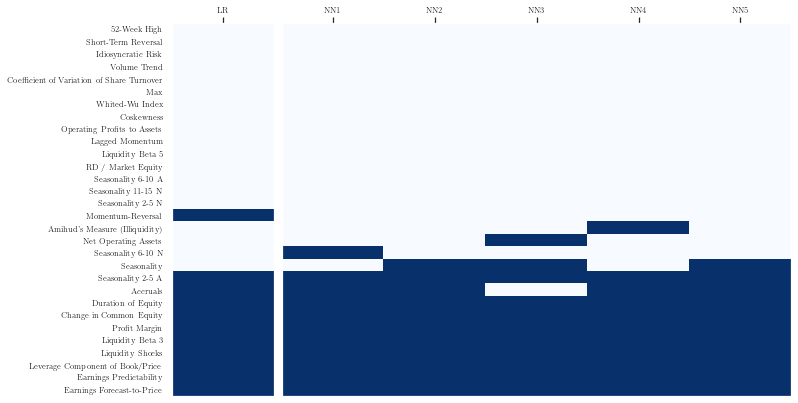

In [69]:
fe_bottom(ig)

### All ensembles agree on top and bottom features by influence, but the middle is mixed (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


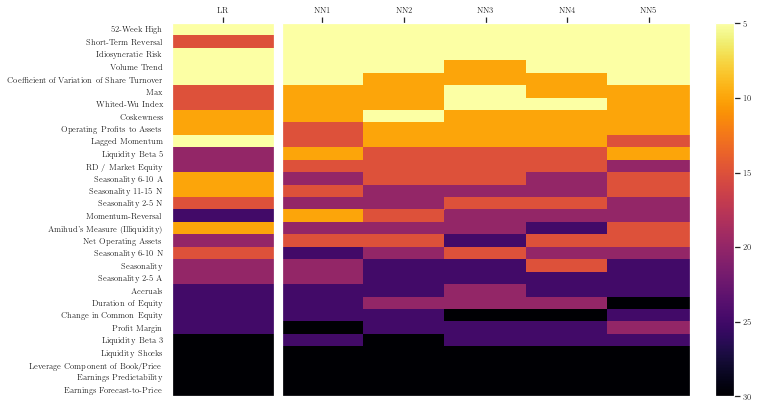

In [72]:
fe_heatmap(ig)

### While IG are same across models, Model Reliances are different (top 10 features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


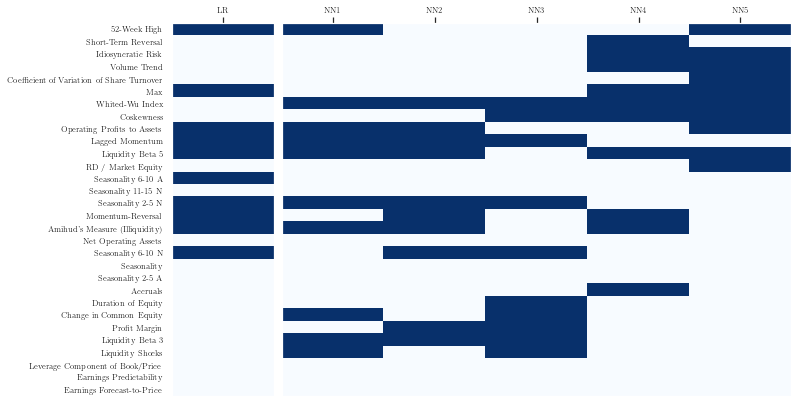

In [75]:
fe_top(mr)

### While IG are same across models, Model Reliances are different (bottom 10 features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


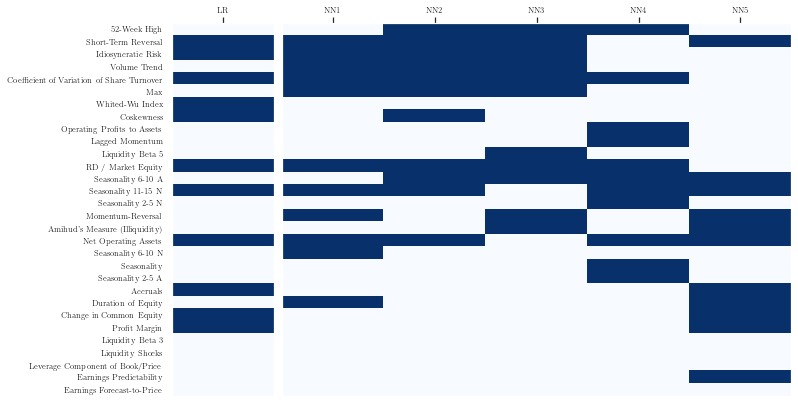

In [74]:
fe_bottom(mr)

### Relative importance of features differes across ensembles (MR)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


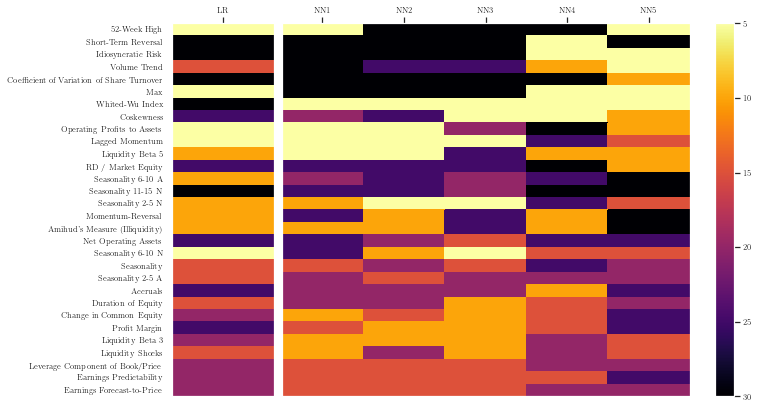

In [76]:
fe_heatmap(mr)

### Why is MR and IG so different? 
IG is high for features whose **values** have big impact on the **value** of the prediction, if other features are at 0. (It **ignores the correlation** of the features.)

MR is high for features whose **distortion** worsens the **error** of the prediction relative to truth. It **takes into account the correlation** of the features.

The issue is the mirror of that in linear regression, coefficients of a variable (IG) can be big and yet the variable can be insignificant due to multicollinearity and a lot more features present (MR)

### MR and IG agree the more the deeper the model

In [28]:
def compare_mr_ig(hidden_layers):
    df_mr = (mr.apply(lambda x: get_orders(x), axis=1)>=20)
    df_mr = name(
            ar, 
            subset_models(
                ar, df_mr, hidden_layers=hidden_layers, ytrain=16
            ).transpose(),
            ["nn_name"])
    df_ig = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
    df_ig = name(
            ar, 
            subset_models(
                ar, df_ig, hidden_layers=hidden_layers, ytrain=16
            ).transpose(),
            ["nn_name"])
    df = pd.concat([df_ig,df_mr,],axis=1)
    df.columns = ["IG", "MR"]
    return df

In [29]:
overlap_top_10 = dict()
for hl in ["32","32,16","32,16,8", "32,16,8,4", "32,16,8,4,2"]:
    df = compare_mr_ig(hl)
    overlap_top_10[hl] = ((df.IG == True) & (df.MR == True)).sum()
overlap_top_10

{'32': 3, '32,16': 3, '32,16,8': 3, '32,16,8,4': 6, '32,16,8,4,2': 9}

**NN1**

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


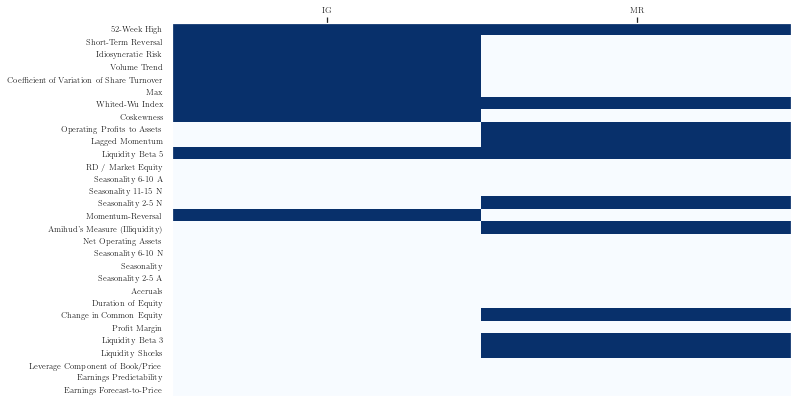

In [31]:
df_heatmap_old(
    compare_mr_ig("32"),
    cmap=plt.cm.Blues,
    show_cbar=False
)

**NN5**

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


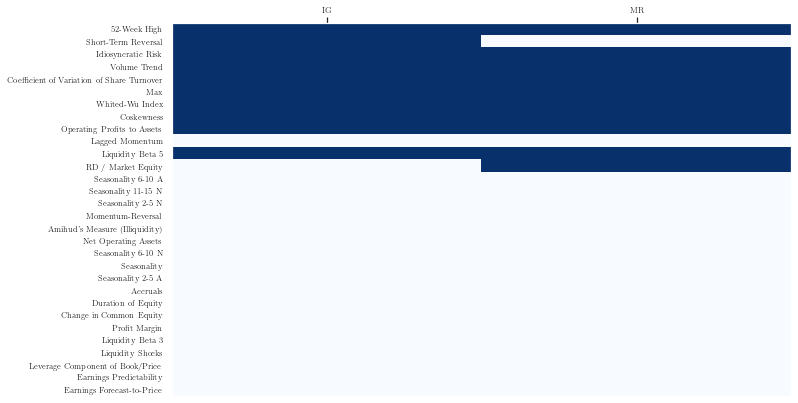

In [32]:
df_heatmap_old(
    compare_mr_ig("32,16,8,4,2"),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

# Robustness check: time stability of feature imporatance

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


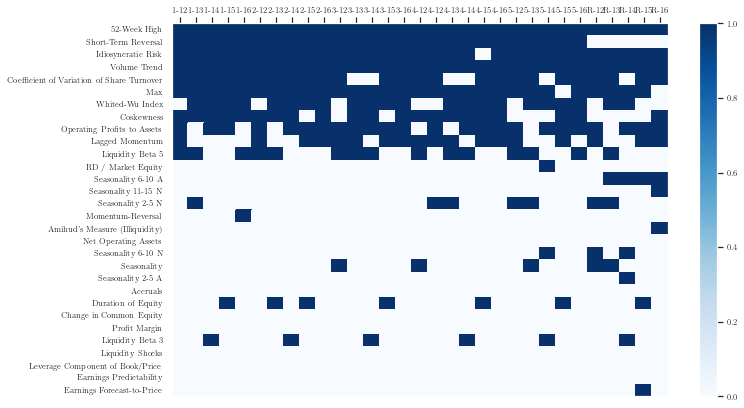

In [34]:
df = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap_old(
    name(ar,df.transpose(), ["nn_name_short", "ytrain"]),
    cmap=plt.cm.Blues,
    show_cbar=True
)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


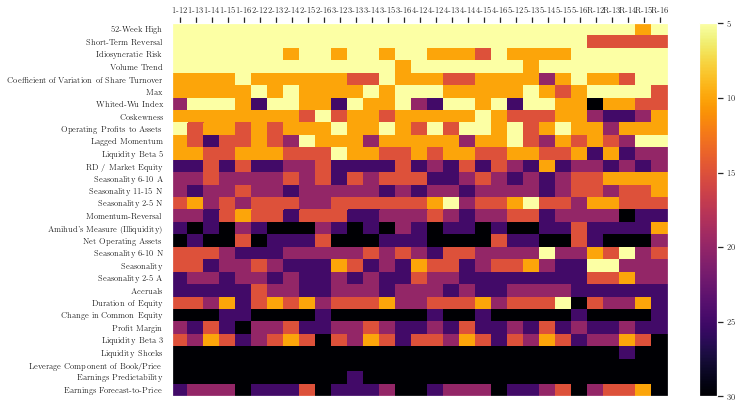

In [80]:
df = ig.apply(lambda x: get_parts(x,6), axis=1)
df_heatmap(
    name(ar,df.transpose(), ["nn_name_short", "ytrain"]),
    cmap=plt.cm.inferno_r,
    vmin=None,
    flip_cbar=True
)

# Simulations Ensembles

In [131]:
ar, pe, ig, mr = load_results('results/simulated/ensembles') 

In [120]:
features_in_simulation

['Coefficient of Variation of Share Turnover',
 'Operating Profits to Assets',
 'Seasonality 6-10 N',
 'Duration of Equity',
 "Amihud's Measure (Illiquidity)"]

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


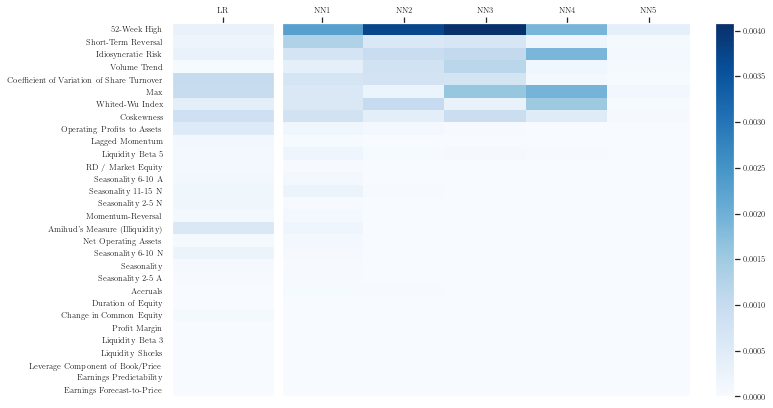

In [115]:
fe_blues(ig)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


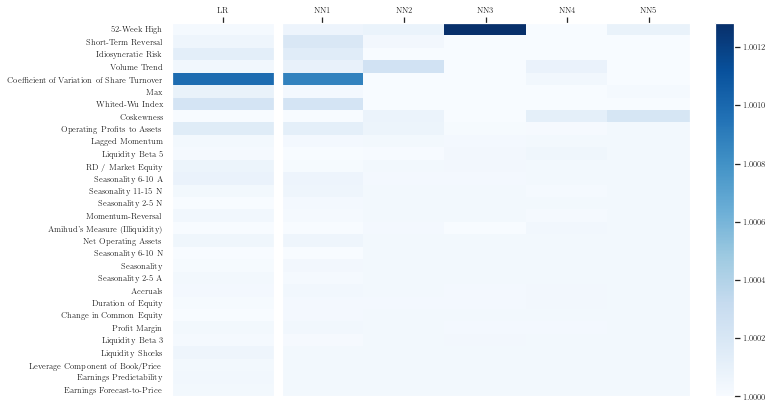

In [133]:
fe_blues(mr, vmin=1)

# Random Seeds

In [93]:
ar, pe, ig, mr = load_results("results/selected/individual")

### Integrated Gradients do not change across seeds (10 most important featues)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


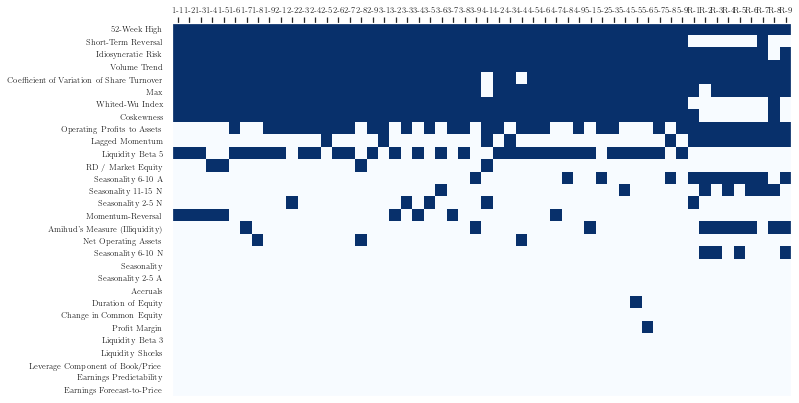

In [96]:
fe_top(ig, mode='seeds')

### Integrated Gradients do not change across seeds (features grouped by importance into categories of 5)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


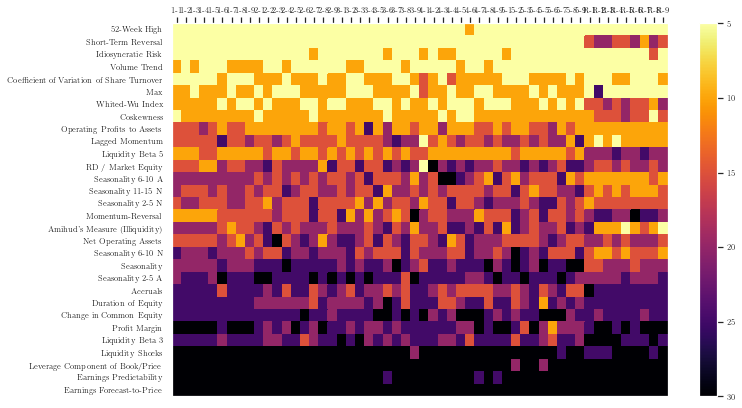

In [97]:
fe_heatmap(ig, mode='seeds')

### This is especially true for simple models. It is also visible in the figure above. This is the correlation of seeds within each NN (lines represnt multiple train-test splits). Cim komplexnejsi model, tim nahodilejsi vahy. Je to tim, ze informace je slaba (na rozdil od simulace s high signal-to-noise). Kdybych mela vysoky signal to noise (obrazky), tohle bych videla az od chvile kdy overfituju

<AxesSubplot:>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


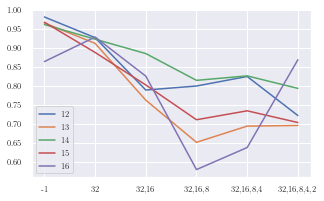

In [98]:
ig_corr = get_corr_of_seeds(ar, ig)
pd.DataFrame(ig_corr).plot()

### Model Reliance changes across seeds considerably (10 most important features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


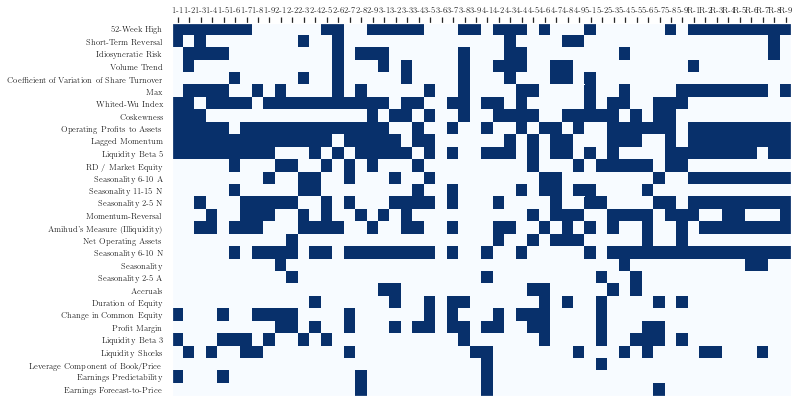

In [99]:
fe_top(mr, mode='seeds')

### Model Reliance changes across seeds considerably (features grouped by importance into categories of 5)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


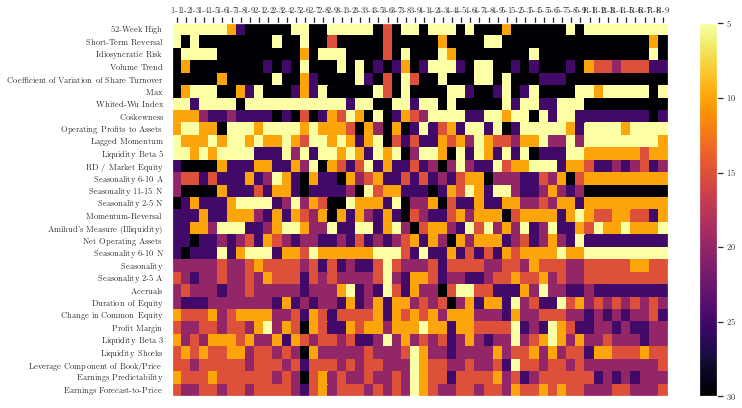

In [100]:
fe_heatmap(mr, mode='seeds')

# Simulations for seeds

In [107]:
from data import Simulated, Selected

In [117]:
dataset = Selected()
dataset.load()
df = dataset.features.sample(5, axis=1, random_state=1)
df.columns = [meta.sc_to_latex.get(s) for s in df.columns]
features_in_simulation = df.columns.tolist()

In [102]:
ar, pe, ig, mr = load_results('results/simulated/individual') 

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


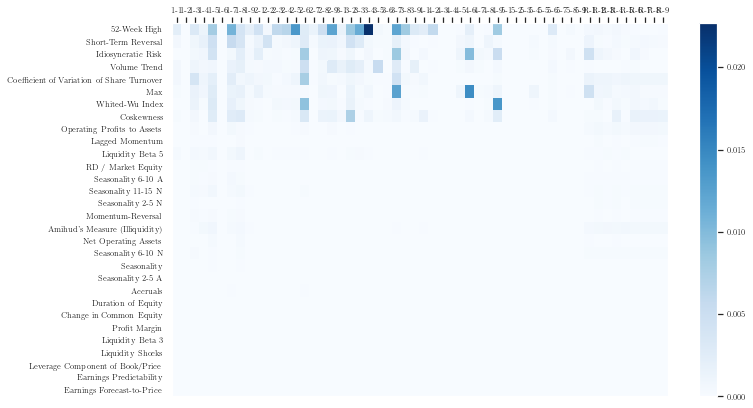

In [110]:
fe_blues(ig, mode='seeds')

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


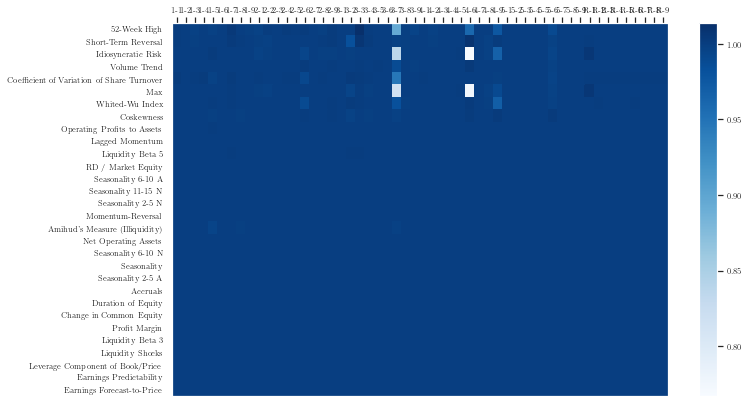

In [112]:
fe_blues(mr, mode='seeds')

# Feature correlations

In [ ]:
from data import Selected 
dataset = Selected() 
dataset.load()

In [101]:
corr = dataset.features[SORTING].corr()
corr.rename(index=meta.sc_to_latex, inplace=True)
corr.columns = corr.index.values

corrplot(corr, size_scale=30, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

NameError: name 'dataset' is not defined

### Closer look to top 10 by IG

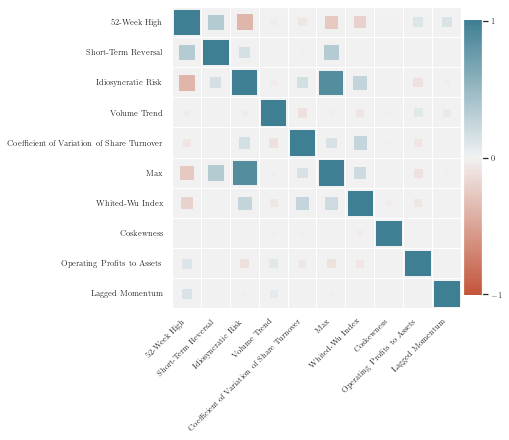

In [30]:
corrplot(corr.iloc[:10,:10], size_scale=600, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

### 10 Most correlated pairs

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


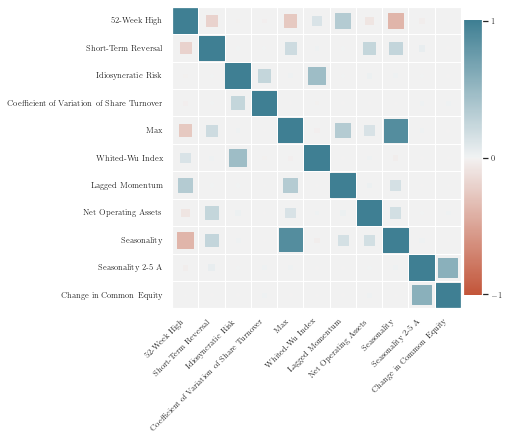

In [31]:
# Get most correlated pairs
so = corr.unstack().abs().sort_values()
hi = so[so!=1].iloc[::2].tail(10).sort_values(ascending=False)
highest = list(set(hi.index.get_level_values(0)).union(set(hi.index.get_level_values(1))))
df = corr.loc[highest,highest]
ordered_index = [s for s in SORTING_LATEX if s in list(df.columns)]
df.columns = ordered_index
df.index = ordered_index
corrplot(df, size_scale=600, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

In [32]:
so = corr.loc[highest,highest].unstack().sort_values()
so[so!=1].iloc[::2].tail(8).sort_values(ascending=False).round(3)

Max                                         Idiosyncratic Risk         0.885
Net Operating Assets                        Change in Common Equity    0.581
Lagged Momentum                             Seasonality                0.474
52-Week High                                Short-Term Reversal        0.348
Short-Term Reversal                         Max                        0.344
Idiosyncratic Risk                          Whited-Wu Index            0.260
Seasonality                                 Seasonality 2-5 A          0.254
Coefficient of Variation of Share Turnover  Whited-Wu Index            0.252
dtype: float64

In [33]:
so[so!=1].iloc[::2].head(2).sort_values(ascending=True).round(3)

52-Week High  Idiosyncratic Risk   -0.385
              Max                  -0.256
dtype: float64

### MR and IG seem to depend on correlation and variance of the feature

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


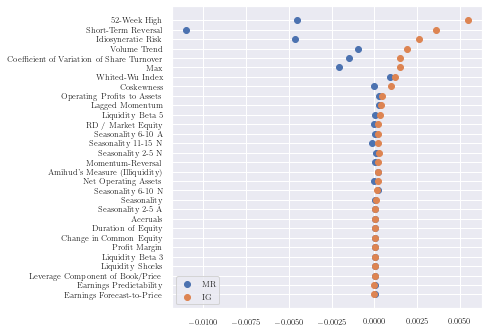

In [34]:
mr16 = subset_models(ar, mr, hidden_layers=None, ytrain=16)-1
ig16 = subset_models(ar, ig, hidden_layers=None, ytrain=16)
means = (pd.DataFrame(mr16.mean(), columns= ["MR"]).rename(index=meta.sc_to_latex))
means["IG"] = ig16.abs().mean().rename(index=meta.sc_to_latex)

fig, axis = plt.subplots(figsize=(8,8))
plt.plot(means, np.arange(len(means)), 'o')
plt.yticks(np.arange(0, len(means.index), 1), means.index.values.tolist())
axis.invert_yaxis()
axis.legend(means.columns.tolist())
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


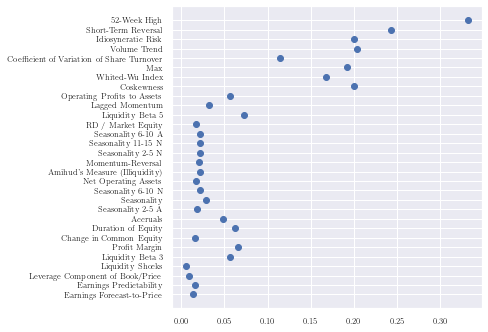

In [50]:
std = dataset.features[SORTING].std()
std.rename(index=meta.sc_to_latex, inplace=True)
std.columns = std.index.values
fig, axis = plt.subplots(figsize=(8,8))
plt.plot(std, np.arange(len(std)), 'o')
plt.yticks(np.arange(0, len(std.index), 1), std.index.values.tolist())
axis.invert_yaxis()
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


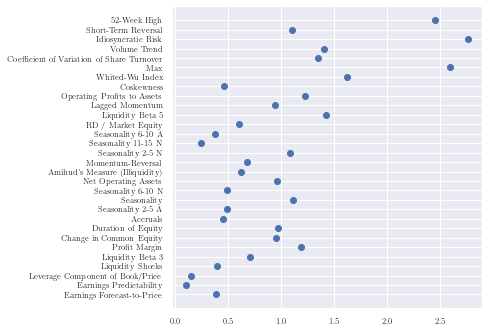

In [35]:
fig, axis = plt.subplots(figsize=(8,8))
plt.plot(corr.abs().sum()-1, np.arange(len(corr)), 'o')
plt.yticks(np.arange(0, len(corr.index), 1), corr.index.values.tolist())
axis.invert_yaxis()
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

# Feature descriptives

### Raw NANs

In [57]:
from data import Filtered
filtered = Filtered()
filtered.load()
nas = filtered.features[SORTING].isna().sum()/filtered.features[SORTING].isna().count()

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


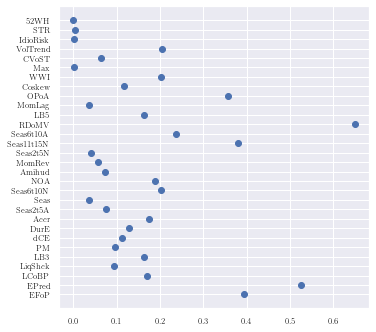

In [66]:
fig, axis = plt.subplots(figsize=(8,8))
plt.plot(nas, np.arange(len(nas)), 'o')
plt.yticks(np.arange(0, len(nas.index), 1), nas.index.values.tolist())
axis.invert_yaxis()
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

### TODO: STD of raw after winsorization but before NAN imputation (to make sure I did not kill some features by normalization) 

### Descriptives of features

In [54]:
df = dataset.features[SORTING].describe().transpose().round(4)
df.rename(index=meta.sc_to_latex, inplace=True)
df = df[df.columns.tolist()[1:]]
#with open('latex/Tables/descr.tex','w') as tf:
#    tf.write(df.to_latex())

In [55]:
df

,mean,std,min,25%,50%,75%,max
52-Week High,-0.0,0.3316,-1.0000,-0.1828,0.0764,0.2445,0.678
Short-Term Reversal,-0.0,0.2430,-0.9831,-0.1276,-0.0178,0.1027,1.000
Idiosyncratic Risk,-0.0,0.1999,-0.2929,-0.1204,-0.0539,0.0528,1.000
Volume Trend,0.0,0.2040,-0.8532,-0.0873,0.0000,0.0979,1.000
Coefficient of Variation of Share Turnover,-0.0,0.1144,-0.1469,-0.0625,-0.0279,0.0170,1.000
Max,0.0,0.1913,-0.2571,-0.1111,-0.0544,0.0416,1.000
Whited-Wu Index,0.0,0.1681,-0.7012,-0.0528,0.0000,0.0489,1.000
Coskewness,-0.0,0.1996,-1.0000,-0.1014,0.0000,0.1074,1.000
Operating Profits to Assets,0.0,0.0562,-0.3581,-0.0122,0.0000,0.0011,1.000
Lagged Momentum,0.0,0.0316,-0.1518,-0.0053,-0.0009,0.0029,1.000


In [38]:
df = meta.signals[~meta.signals.important_otmh_global_liquid.isna()]
df = df[["name_tex", "tex_cite", "class", "class2", "freq", "kelly_sc", "journal"]]
df.set_index('name_tex', inplace=True)
df = df.loc[SORTING_LATEX]

In [39]:
df.head()

,tex_cite,class,class2,freq,kelly_sc,journal
name_tex,,,,,,
52-Week High,george200452,frictions,other,monthly,NaN,JF
Short-Term Reversal,jegadeesh1990evidence,frictions,other,monthly,mom1m,JF
Idiosyncratic Risk,ang2006cross,frictions,other,monthly,idiovol,JF
Volume Trend,haugen1996commonality,frictions,other,monthly,NaN,JFE
Coefficient of Variation of Share Turnover,chordia2001trading,frictions,other,monthly,std_turn,JFE


In [40]:
df.to_latex()

"\\begin{tabular}{lllllll}\n\\toprule\n{} &                    tex\\_cite &      class &         class2 &         freq &  kelly\\_sc & journal \\\\\nname\\_tex                                   &                             &            &                &              &           &         \\\\\n\\midrule\n52-Week High                               &                george200452 &  frictions &          other &      monthly &       NaN &      JF \\\\\nShort-Term Reversal                        &       jegadeesh1990evidence &  frictions &          other &      monthly &    mom1m  &      JF \\\\\nIdiosyncratic Risk                         &                ang2006cross &  frictions &          other &      monthly &   idiovol &      JF \\\\\nVolume Trend                               &       haugen1996commonality &  frictions &          other &      monthly &       NaN &     JFE \\\\\nCoefficient of Variation of Share Turnover &          chordia2001trading &  frictions &          other &    

### Plot of returns

In [82]:
# zscore more than 8 is considered outlier
r_without_outliers = dt.targets.r[np.abs((dt.targets['r'] - dt.targets['r'].mean())/dt.targets['r'].std(ddof=0)<8)]

r_without_outliers.plot.hist(grid=True, bins=100, rwidth=0.9)
plt.xlabel('Monthly Return')
plt.ylabel('Number of Observations')
fig = Figure(plt.gcf())
fig.fit()

NameError: name 'dt' is not defined

### Simulations

In [ ]:
r_crop = dt.targets.r[np.abs((dt.targets['r'] - dt.targets['r'].mean())/dt.targets['r'].std(ddof=0)<8)]
r_simul_crop = r_simul[np.abs((r_simul - r_simul.mean())/r_simul.std(ddof=0)<8)]

r_crop.plot.hist(grid=True, bins=50, rwidth=0.9, range=[-1, 1],alpha=0.5, label="True")
r_simul_crop.plot.hist(grid=True, bins=50, rwidth=0.9, range=[-1, 1],alpha=0.5, label="Simulated")
plt.xlabel('Monthly Return')
plt.ylabel('Number of Observations')
plt.legend(loc='upper right')
fig = LatexFigure(plt.gcf())
fig.fit()

In [ ]:
# Average annualized volatility 
print("vol_true")
vol_true = dt.targets.r.groupby(pd.Grouper(level=0)).apply(lambda group: group.std()*np.sqrt(12)).mean() 
print(vol_true)

print("vol_simul")
vol_simul = r_simul.groupby(pd.Grouper(level=0)).apply(lambda group: group.std()*np.sqrt(12)).mean() 
print(vol_simul)